In [7]:
# test code works after changes for serialization 

import librosa

from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

# audio is (5864816,) in [-1, 1]
# audio, sr = librosa.load('loop.mp3', sr=44100, mono=True)

audio, sr = librosa.load('loop.mp3', sr=44100, mono=True)


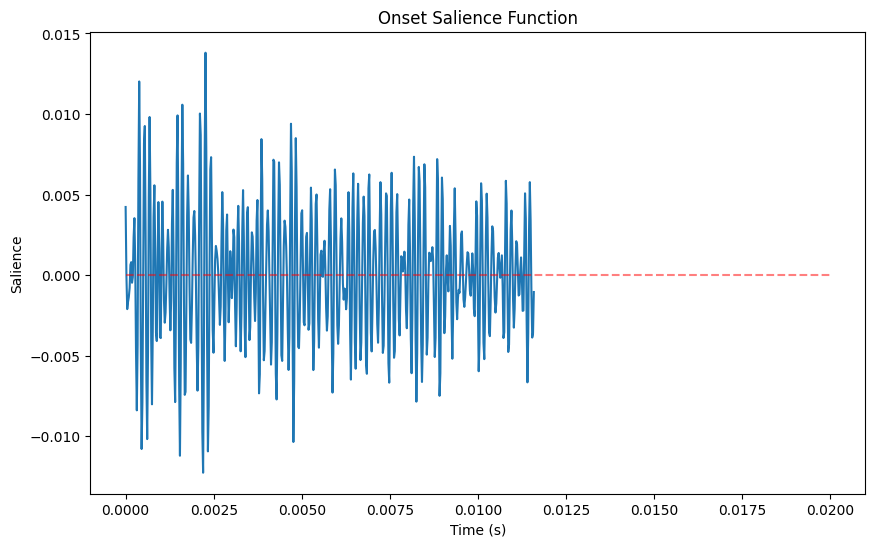

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

from pysndfx import AudioEffectsChain
# Create an AudioEffectsChain with the supplied effects
fx = (
    AudioEffectsChain()
)

# Apply the effects and return the results
audio = fx(audio)

start = int(-5.5 * 512)
end = start + 1 * 512

audio2 = audio[start:end]

t = np.arange(len(audio2)) / sr

fig, ax = plt.subplots(figsize=(10, 6))


plt.plot(t, audio2)

# onset salience is (13301,) in [0, 1]
onset_salience = compute_onset_salience(audio2, sr)
plt.plot(np.arange(len(onset_salience)) / FRAME_RATE, onset_salience, color='red', alpha=0.5, linestyle='dashed')

# peaks 
peaks = find_peaks(onset_salience)
peaks = peaks[onset_salience[peaks] > 0.01]
plt.scatter(peaks / FRAME_RATE, onset_salience[peaks], color='red', s=10)

plt.xlabel('Time (s)')
plt.ylabel('Salience')
plt.title('Onset Salience Function')

# play audio
import IPython.display as ipd
ipd.Audio(filename='loop.mp3')

# save plot with upscaled resolution
plt.savefig('onset_salience.png', dpi=300)


In [9]:
type(onset_salience)

numpy.ndarray

In [10]:
import torch
from ddc_onset import Difficulty

import numpy as np
from typing import Optional
import os

from ddc_onset.cnn import SpectrogramNormalizer, PlacementCNN
from ddc_onset.spectral import SpectrogramExtractor

class DDC_Onset(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.extractor = SpectrogramExtractor()
        self.normalizer = SpectrogramNormalizer()
        self.placement_cnn = PlacementCNN()
    
    def forward(self, audio: torch.Tensor, difficulty: int = 4):
        '''
            audio: Audio as float32 [num_samples].
            
        '''        
        
        difficulties = torch.tensor(
            [difficulty], dtype=torch.int64
        )
        spectrogram = self.extractor(audio.view(1, -1))
        onset_salience = self.placement_cnn(self.normalizer(spectrogram[0]), difficulties)[0]
        
        return onset_salience

    # def find_peaks(self, onset_salience: np.ndarray):
    #     try:
    #         from scipy.signal import argrelextrema
    #     except ImportError:
    #         raise Exception(
    #             "Scipy required for finding peaks. Please install scipy with `pip install scipy`."
    #         )
    #     onset_salience_smoothed = np.convolve(onset_salience, np.hamming(5), "same")
    #     peaks = argrelextrema(onset_salience_smoothed, np.greater_equal, order=1)[0]
    #     return peaks

    @torch.jit.ignore
    def serialize(self, save_folder, filename=None):

        os.makedirs(save_folder, exist_ok=True)

        if filename is None:
            filename = f'DDC_Onset.pt'
        is_train = self.training
        self.eval()
        save_path = os.path.join(save_folder, filename)

        scr = torch.jit.script(self)
        # save model
        with open(save_path, "wb") as f:
            torch.jit.save(scr, f)

        if is_train:
            self.train()



In [11]:
ddc_onset = DDC_Onset()
ddc_onset.serialize('./')

Hop size:  441 Sample Rate:  44100 Frame Rate:  100


In [17]:
import librosa
import torch
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

from pysndfx import AudioEffectsChain
# Create an AudioEffectsChain with the supplied effects
fx = (
    AudioEffectsChain().pitch(1200) # Increase pitch by 1200 cents (1 octave up)
)



# Load audio file
audio_file, sr = librosa.load('loop.mp3', sr=44100, mono=True)
audio_file = audio_file[:4096 * 10]  # First 10 seconds

# Apply the effects and return the results
audio_file = fx(audio_file)

# Define hop size and overlap
chunk_size = 4096
overlap = 32  # Overlap of 441 samples

# Split audio into chunks with overlap
audios = [audio_file[i:i + chunk_size] for i in range(0, len(audio_file), overlap)]

# Placeholder for frame rate
FRAME_RATE = 100

# Prepare data for Bokeh plotting
output_notebook()  # Outputs plot inside the notebook
p = figure(title="Audio Waveform and Onset Salience", width=800, height=400,
           x_axis_label='Time (seconds)', y_axis_label='Amplitude')

# Plot the entire audio waveform
p.line(np.arange(len(audio_file)) / sr, audio_file, line_width=1, color="blue", legend_label="Waveform")

# Analyze each chunk and plot
max_salience_points_not_rt = {'time': [], 'salience': []}
max_salience_points_rt = {'time': [], 'salience': []}

prev_max_salience = 0
tolerance = 0.1

for i, audio in enumerate(audios):
    test_audio = torch.tensor(audio)
    onset_salience = ddc_onset(test_audio)  # Ensure this function is defined
    max_salience_ix = torch.argmax(onset_salience).item()
    max_salience = onset_salience[max_salience_ix].item()
    max_salience_t = max_salience_ix / FRAME_RATE
    frame_start_time = i * overlap / sr    
    time = frame_start_time + max_salience_t
    
    # check if max_salience is above tolerance and also larger than previous max_salience (if zero, then set to zero)
    
    if max_salience < tolerance :
        max_salience = 0
    
    NewMaxSalienceAvailable = False
    if max_salience > prev_max_salience: 
        NewMaxSalienceAvailable = True
        prev_max_salience = max_salience
    elif max_salience == 0 and prev_max_salience > 0:
        prev_max_salience = 0

    if NewMaxSalienceAvailable:
        max_salience_points_not_rt['time'].append(time)
        max_salience_points_not_rt['salience'].append(max_salience)
    
        end_time = frame_start_time + len(audio) / sr
        max_salience_points_rt['time'].append(end_time)
        max_salience_points_rt['salience'].append(max_salience)

# sort by time
max_salience_points_not_rt = {k: v for k, v in sorted(max_salience_points_not_rt.items(), key=lambda item: item[0])}
max_salience_points_rt = {k: v for k, v in sorted(max_salience_points_rt.items(), key=lambda item: item[0])}

# Add scatter points for max salience
p.scatter(max_salience_points_not_rt['time'], max_salience_points_not_rt['salience'], color='red', size=3, legend_label="Salience (Not Real-Time)")
p.scatter(max_salience_points_rt['time'], max_salience_points_rt['salience'], color='green', size=3, legend_label="Salience (Real-Time)")

p.legend.location = "bottom_right"
p.legend.click_policy = "hide"

show(p)

# save plot with upscaled resolution
from bokeh.io import save, output_file


# output_file('onset_salience.html')
# save(p)

Loading BokehJS ...